In [1]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

#pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

W0601 22:11:03.623629 12220 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'Audio-Technica ATH Professional Studio Monitor Headphones'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text']]
###################################################

In [3]:
import re

def remove_banned(s,words):
    #words = sorted(words, key=len, reverse=True)
    pattern = '|'.join(words)
    s = re.sub(pattern, '', s, flags = re.I) # remove words
    s = re.sub(r'[0-9]+', '', s) # remove numbers
    s = re.sub('\s+', ' ', s, flags = re.I) # remove extra blank space'
    return s

bannedWords = ['hi', 'hi you', 'hello', 'and you']
s = "Hi, Hello, hi you, How are Tim and you doing"

print(remove_banned(s,bannedWords))

, , you, How are Tim doing


In [4]:
word_list = pd.read_csv('sentiment/wordlist.csv')
word_list = word_list.dropna()
word_list['count'] = word_list['word'].apply(lambda x: len(x.split()))
wd2 = word_list

In [5]:
word_list = word_list.sort_values(by=['count'],ascending =False).reset_index(drop=True)
word_list['word'] = word_list['word'].apply(lambda x: x+' ')
wordlist = word_list.loc[word_list['count']<10, ['word']]
wordlist = wordlist['word'].tolist()

In [6]:
one_word = wd2[wd2['count']==1]['word'].tolist()
mylist = ['love','loves','loved','like','likes','liked','enjoy','enjoys','enjoyed',
            'hate','hates','hated','do','does','did','don','don\'t','want','wants','wanted']
subject = ['headphones','headphone','ATH','Technica']
one_word.extend(mylist)
one_word.extend(subject)
one_word = set(one_word)

In [7]:
def clean_review(x):

    words = one_word

    resultwords  = [word for word in re.split("[.,; :-?!&]+",x) if word.lower() not in words]
    result = ' '.join(resultwords)
    return result

In [8]:
reviews.head()

,text
0,great headphones except it hurts my head after...
1,"Because of the sound cancellation, I'd find my..."
2,Was a little too tight for me though
3,Fantastic sound quality and got here pretty qu...
4,Do not hesitate to order these


In [9]:
reviews['removed'] = reviews['text'].apply(lambda x: remove_banned(x,wordlist))
reviews['removed'] = reviews['text'].apply(lambda x: clean_review(x))

In [10]:
def clean_punct(line):
    line = re.sub('[0-9%]+','',line)
    line = re.sub(' +', ' ',line)
    return line.strip()

In [11]:
reviews['removed'] = reviews['removed'].apply(lambda x: clean_punct(x))

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from itertools import islice


In [13]:
cvec = CountVectorizer(stop_words='english', min_df=0.001, max_df=.2, ngram_range=(2,3))
cvec.fit(reviews.removed)
len(cvec.vocabulary_)
#list(islice(cvec.vocabulary_.items(), 20))

117

In [14]:
cvec_counts = cvec.transform(reviews.text)
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
#counts_df.sort_values(by='occurrences', ascending=False).head(20)

sparse matrix shape: (14195, 117)
nonzero count: 3328
sparsity: 0.20%


In [15]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=False).reset_index(drop=True)

In [16]:
key_words = weights_df[weights_df.weight>=0.0005]

In [17]:
len(key_words)

110

In [18]:
key_words

,term,weight
0,audio technica,0.012694
1,listening music,0.007190
2,price range,0.006690
3,coiled cable,0.005568
4,listen music,0.005326
5,beats dre,0.004655
6,coiled cord,0.004239
7,noise cancelling,0.003852
8,ear pads,0.003756
9,ve heard,0.003639


In [19]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

In [20]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)


Instructions for updating:
Colocations handled automatically by placer.


W0601 22:16:28.682905 12220 deprecation.py:323] From C:\Users\betty\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [21]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    key_words['embedding'] = pd.Series(list(session.run(embed(list(key_words['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0601 22:16:49.193685 12220 saver.py:1483] Saver not created because there are no variables in the graph to restore
C:\Users\betty\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


time1: 2.6945340633392334


In [22]:
terms = key_words['term'].tolist()
embs = key_words['embedding'].tolist()

In [23]:
##
X = np.array(embs,)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(embs)

In [24]:
X.shape

(110, 512)

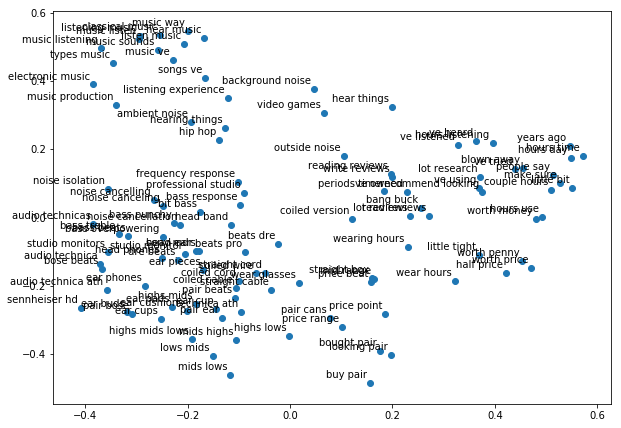

In [26]:
import matplotlib.pyplot as plt

labels = terms 
plt.figure(figsize=(10, 7))  
plt.subplots_adjust(bottom=0.1)  
plt.scatter(X2[:,0],X2[:,1], label='True Position')

for label, x, y in zip(labels, X2[:, 0], X2[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()  

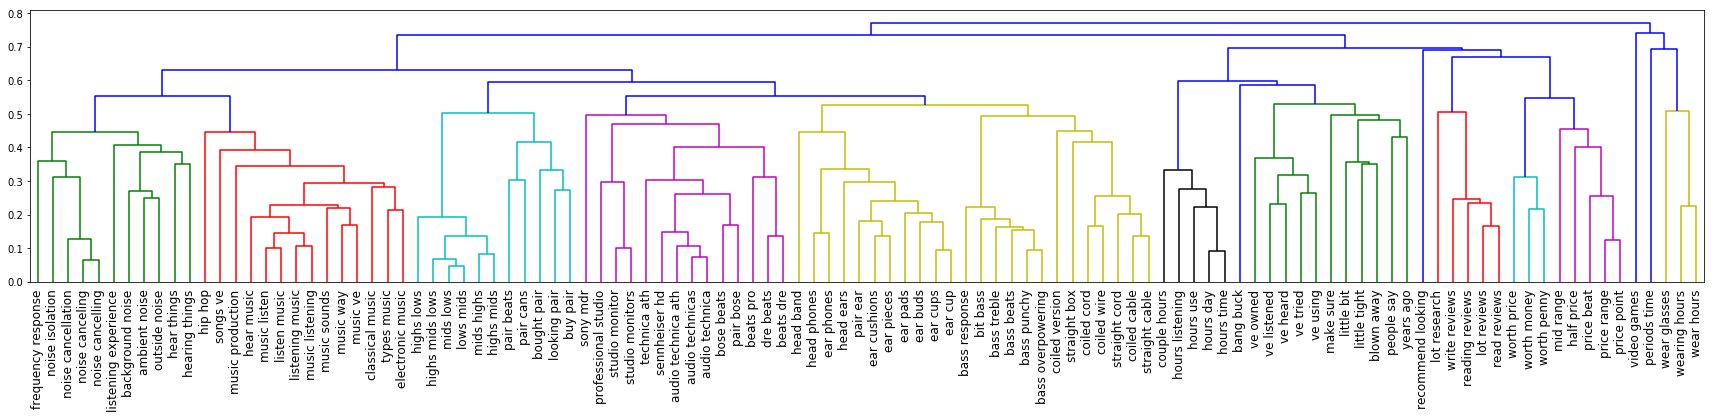

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist

#dist_condensed = pdist(X)
#linked = linkage(X, 'single',metric='cosine',optimal_ordering=True)
linked = linkage(X, 'average', metric='cosine',optimal_ordering=True)
labelList = terms

plt.figure(figsize=(30, 5))  
dh = dendrogram(linked,  
            orientation='top',
            labels=labelList,
            leaf_font_size=12,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [28]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.
The scikit-learn version is 0.21.2.


In [29]:
import matplotlib.pyplot as plt  
import pandas as pd  
%matplotlib inline
import numpy as np  
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold =0.45)  
term_clusters = cluster.fit_predict(X)  
term_clusters

array([ 8,  3,  6,  0,  3,  8,  0,  2,  1, 15,  1, 15, 19,  8,  8,  6, 10,
        3,  5,  2, 21,  3,  1, 16, 19, 23, 25, 12,  8,  1,  5, 14, 15,  7,
       22,  2,  0,  2, 16, 11,  9, 15, 11,  3, 20,  7,  4,  0,  3, 14, 19,
        9,  8,  2,  1,  2, 19,  6, 14,  2,  1,  7,  3, 17,  0,  8,  8, 15,
        2,  9,  3,  1,  2,  8,  4,  0,  0,  2,  3,  1,  5,  9,  9,  3,  3,
       18,  3,  7, 13, 16,  8, 24, 11, 19,  1,  1, 16,  1, 10, 19,  2, 22,
        6, 22,  3,  3, 22,  7, 22, 22], dtype=int64)

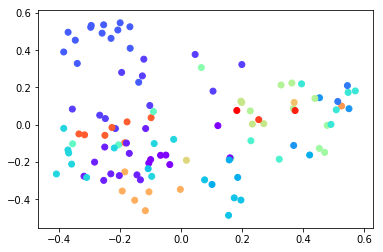

In [30]:
plt.scatter(X2[:,0],X2[:,1], c=cluster.labels_, cmap='rainbow') 

In [31]:
cluster_numbers = np.amax(term_clusters)
print('Number of keyword clusters:',cluster_numbers)

Number of keyword clusters: 25


In [32]:
cluster_data = {'term':terms, 'cluster':term_clusters}
df_cluster = pd.DataFrame(cluster_data)

In [33]:
df_cluster.to_csv("output/ATH_headphone_keywords.csv",index=False)
####### load
df_cluster = pd.read_csv("output/ATH_headphone_keywords.csv")
cluster_numbers = np.amax(df_cluster.cluster.tolist())

In [34]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    df_cluster['embedding'] = pd.Series(list(session.run(embed(list(df_cluster['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0601 22:18:19.111306 12220 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 3.7859139442443848


In [35]:
df_cluster.head()

,term,cluster,embedding
0,audio technica,8,"[0.06332447, 0.015068867, -0.042115867, 0.0494..."
1,listening music,3,"[-0.045451768, -0.04760361, -0.034584887, 0.04..."
2,price range,6,"[0.041651044, 0.0057591093, -0.047061507, 0.06..."
3,coiled cable,0,"[0.053848922, 0.04042782, -0.035096023, 0.0360..."
4,listen music,3,"[-0.046671312, -0.043211374, -0.012437216, 0.0..."


In [36]:
group = []
emb_group = []
for i in range(cluster_numbers+1):
    terms_in_group = df_cluster.loc[df_cluster['cluster']==i]['term'].tolist()
    embs_in_group = df_cluster.loc[df_cluster['cluster']==i]['embedding'].tolist()
    if len(terms_in_group)>=3:
        group.append(terms_in_group)
        emb_group.append(embs_in_group)
        print('Group '+str(i)+':\n',terms_in_group,'\n')

Group 0:
 ['coiled cable', 'coiled cord', 'straight cable', 'coiled version', 'straight cord', 'coiled wire', 'straight box'] 

Group 1:
 ['ear pads', 'ear cups', 'head phones', 'ear buds', 'ear phones', 'ear pieces', 'head band', 'ear cushions', 'head ears', 'pair ear', 'ear cup'] 

Group 2:
 ['noise cancelling', 'noise canceling', 'noise cancellation', 'frequency response', 'hear things', 'listening experience', 'background noise', 'noise isolation', 'ambient noise', 'outside noise', 'hearing things'] 

Group 3:
 ['listening music', 'listen music', 'hear music', 'hip hop', 'music listening', 'classical music', 'electronic music', 'music sounds', 'music production', 'songs ve', 'music listen', 'types music', 'music ve', 'music way'] 

Group 5:
 ['little bit', 'blown away', 'little tight'] 

Group 6:
 ['price range', 'price point', 'half price', 'price beat'] 

Group 7:
 ['pair beats', 'buy pair', 'bought pair', 'looking pair', 'pair cans'] 

Group 8:
 ['audio technica', 'beats dre', '

In [37]:
avg_embs = []

for embs in emb_group:
    temp_avg = np.zeros(len(embs[0]))
    for term_emb1 in embs:
        temp_avg = temp_avg+term_emb1
        term_avg = temp_avg/len(embs)
    avg_embs.append(term_avg)

In [38]:
data2 = {'terms':group, 'avg_emb':avg_embs}
cluster_embs = pd.DataFrame(data2)
cluster_embs

,terms,avg_emb
0,"[coiled cable, coiled cord, straight cable, co...","[0.04675934091210365, 0.009738384862430394, -0..."
1,"[ear pads, ear cups, head phones, ear buds, ea...","[0.015669838192645166, 0.0504175429655747, -0...."
2,"[noise cancelling, noise canceling, noise canc...","[0.013086500408297235, 0.008004377977075901, -..."
3,"[listening music, listen music, hear music, hi...","[-0.030218500943322266, -0.0278591499830197, -..."
4,"[little bit, blown away, little tight]","[0.017267088716228802, 0.0018602112929026287, ..."
5,"[price range, price point, half price, price b...","[0.018818118143826723, 0.021023027482442558, -..."
6,"[pair beats, buy pair, bought pair, looking pa...","[-0.025208820588886738, -0.020758829079568386,..."
7,"[audio technica, beats dre, technica ath, audi...","[0.06438378877937793, 0.0037000795477069915, -..."
8,"[hours day, hours time, hours use, couple hour...","[-0.061867088079452515, 0.04231829382479191, -..."
9,"[studio monitor, studio monitors, professional...","[0.014754102177297076, -0.01631684477130572, -..."


In [39]:
import pickle
pickle.dump(cluster_embs, open("output/ATH_headphone_embs.pickle", "wb"))

In [40]:
test_load = pickle.load(open("output/ATH_headphone_embs.pickle", "rb"))
test_load

,terms,avg_emb
0,"[coiled cable, coiled cord, straight cable, co...","[0.04675934091210365, 0.009738384862430394, -0..."
1,"[ear pads, ear cups, head phones, ear buds, ea...","[0.015669838192645166, 0.0504175429655747, -0...."
2,"[noise cancelling, noise canceling, noise canc...","[0.013086500408297235, 0.008004377977075901, -..."
3,"[listening music, listen music, hear music, hi...","[-0.030218500943322266, -0.0278591499830197, -..."
4,"[little bit, blown away, little tight]","[0.017267088716228802, 0.0018602112929026287, ..."
5,"[price range, price point, half price, price b...","[0.018818118143826723, 0.021023027482442558, -..."
6,"[pair beats, buy pair, bought pair, looking pa...","[-0.025208820588886738, -0.020758829079568386,..."
7,"[audio technica, beats dre, technica ath, audi...","[0.06438378877937793, 0.0037000795477069915, -..."
8,"[hours day, hours time, hours use, couple hour...","[-0.061867088079452515, 0.04231829382479191, -..."
9,"[studio monitor, studio monitors, professional...","[0.014754102177297076, -0.01631684477130572, -..."


In [41]:
cluster_centers = test_load['avg_emb'].tolist()
cluster_centers_labels = test_load['terms'].tolist()

In [42]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'Audio-Technica ATH Professional Studio Monitor Headphones'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text']]
###################################################

In [43]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    reviews['embedding'] = pd.Series(list(session.run(embed(list(reviews['text'])))))
reviews.head()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0601 22:20:16.900683 12220 saver.py:1483] Saver not created because there are no variables in the graph to restore


,text,embedding
0,great headphones except it hurts my head after...,"[0.023935653, 0.0034492523, -0.0056872102, 0.0..."
1,"Because of the sound cancellation, I'd find my...","[-0.010593622, 0.055789355, 0.030662157, -0.03..."
2,Was a little too tight for me though,"[0.025174437, -0.011178963, -0.012607803, -0.0..."
3,Fantastic sound quality and got here pretty qu...,"[-0.009091104, -0.046820533, -0.00013145777, -..."
4,Do not hesitate to order these,"[-0.014508884, -0.04255618, -0.013950949, 0.01..."


In [44]:
def find_closest(centers, text_emb):
    distances = np.inner(centers,text_emb)
    if np.amax(distances)<=0.5:
        return -1
    else:
        return np.where(distances == np.amax(distances))[0][0]

In [45]:
reviews['cluster'] = reviews['embedding'].apply(lambda x: find_closest(cluster_centers,x))
reviews

,text,embedding,cluster
0,great headphones except it hurts my head after...,"[0.023935653, 0.0034492523, -0.0056872102, 0.0...",1
1,"Because of the sound cancellation, I'd find my...","[-0.010593622, 0.055789355, 0.030662157, -0.03...",2
2,Was a little too tight for me though,"[0.025174437, -0.011178963, -0.012607803, -0.0...",-1
3,Fantastic sound quality and got here pretty qu...,"[-0.009091104, -0.046820533, -0.00013145777, -...",-1
4,Do not hesitate to order these,"[-0.014508884, -0.04255618, -0.013950949, 0.01...",6
5,Great sound and comfortable to boot,"[0.063125364, -0.06527017, -0.029320424, 0.024...",-1
6,I use them for everything from mp3 headphones ...,"[0.01967602, 0.058391973, -0.014327442, -0.009...",7
7,Seriously worth it and doubly so if they're on...,"[-0.027947301, 0.07377788, -0.047472607, -0.01...",-1
8,I've used these headphones for a year and a ha...,"[0.047727227, -0.00696438, -0.024244735, 0.000...",7
9,They are also comfortable on your ears and do ...,"[0.060537763, 0.061116703, -0.010659479, 0.010...",1


In [46]:
len1 = len(cluster_centers)
for i in range(len1):
    s1 = reviews.loc[reviews['cluster']==i,['text']]['text'].tolist()
    print('cluster',i,'----  contents:',cluster_centers_labels[i],'\n')
    print(s1)
    print('\n\n')

cluster 0 ----  contents: ['coiled cable', 'coiled cord', 'straight cable', 'coiled version', 'straight cord', 'coiled wire', 'straight box'] 

['I suggest getting the coiled cable and not the straight one', 'You should purchase the version with DETACHABLE CABLE', 'The cable is very long and heavy, and high quality, I highly recommend the version with the coiled and removable cable', 'Spring on cord protects against flex damage', "There is one or two cons; I ordered the straight cord instead of the coiled, which was a bad decision on my part, because you're lugging around a 10 foot cord", "I'm not sure if I need another adapter", 'Telephone style cable and 1/4 & 1/8 inch adapters are a huge bonus', "The cable is very thick and high quality, and the 1/4'' adapter screws on to make it seem like a native 1/4'' cable when you use it", '- The cable is sufficiently long', '- Wish the cable was detachable', 'Because with a long cable there is always a danger of accidentally pulling on it', 'T